Train Accuracy: 1.00, Train F1 Score: 1.00
Test Accuracy: 0.50, Test F1 Score: 0.50
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best Score: 0.55
Optimized Test Accuracy: 0.54
Optimized Test F1 Score: 0.53
Best ccp_alpha: 0.000428359788359789 with cross-validated accuracy: 0.5608571428571428


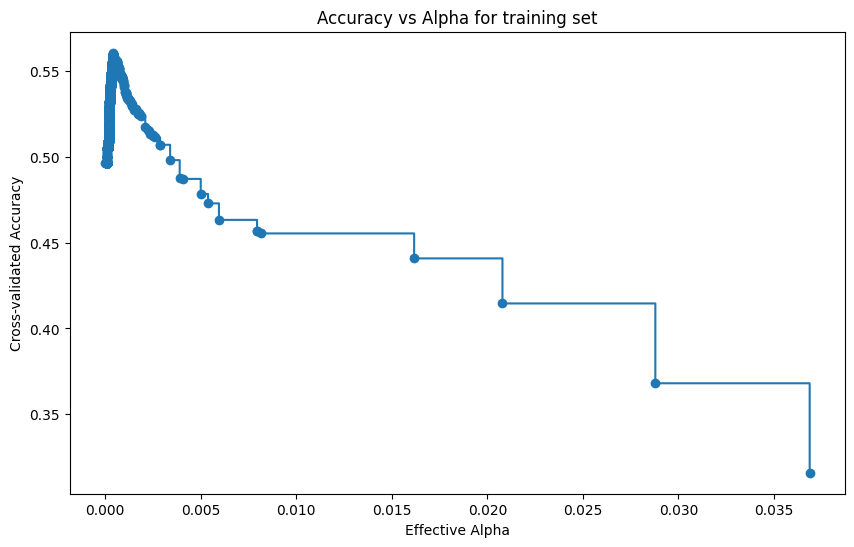

Pruned Test Accuracy: 0.5435555555555556
Pruned Test F1 Score: 0.533049838992002


In [3]:
# Procediamo con le strategie di ottimizzazione escludendo la parte di SMOTE.

# Importo le librerie necessarie
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
import numpy as np

from sklearn.model_selection import cross_val_score

# Carico il dataset
df = pd.read_csv("../our_analyses/dataset_prepared.csv")
# Pre-elaborazione dei dati come nel file del professore
genre_groups = {
    'j-dance': 0, 'techno': 0, 'chicago-house': 0, 'breakbeat': 0, 
        'happy': 1, 'sleep': 1, 'study': 1, 'disney': 1, 
        'bluegrass': 2, 'forro': 2, 'mandopop': 2, 'iranian': 2, 'indian': 2, 'brazil': 2, 
        'black-metal': 3, 'industrial': 3, 
        'j-idol': 4, 'spanish': 4, 'afrobeat': 4, 
        'idm': 5
}
genre_labels = ['Metal and Related', 'Metal/Rock', 'Country/Folk', 'Pop/Commercial', 'World', 'Ambient/New Age', 'Other', 'Indian']


# Mappatura dei generi del dataframe ai gruppi di generi
df['genre_group'] = df['genre'].map(genre_groups).astype(int)

df = df.drop(['name', 'artists', 'album_name', 'genre', 'explicit', 'mode', 'time_signature'], axis=1)
attributes = [col for col in df.columns if col != 'genre_group']
X = df[attributes].values
y = df['genre_group']

# Divisione in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Normalizzazione dei dati
norm = StandardScaler()
X_train_norm = norm.fit_transform(X_train)
X_test_norm = norm.transform(X_test)

# Riduzione della dimensionalità con PCA
pca = PCA(n_components=0.95)  # Manteniamo il 95% della varianza
X_train_pca = pca.fit_transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

# Addestramento del Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_train_pca, y_train)

# Valutazione del modello
y_train_pred = dt.predict(X_train_pca)
y_test_pred = dt.predict(X_test_pca)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Stampa dei risultati
print(f"Train Accuracy: {train_accuracy:.2f}, Train F1 Score: {train_f1:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}, Test F1 Score: {test_f1:.2f}")

# Ottimizzazione degli iperparametri con GridSearchCV
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# Migliori parametri e punteggio
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score:.2f}")

# Ripetere la valutazione del modello con i parametri ottimizzati
dt_optimized = DecisionTreeClassifier(**best_params, random_state=1)
dt_optimized.fit(X_train_pca, y_train)
y_test_pred_optimized = dt_optimized.predict(X_test_pca)
optimized_test_accuracy = accuracy_score(y_test, y_test_pred_optimized)
optimized_test_f1 = f1_score(y_test, y_test_pred_optimized, average='weighted')

print(f"Optimized Test Accuracy: {optimized_test_accuracy:.2f}")
print(f"Optimized Test F1 Score: {optimized_test_f1:.2f}")

# Ottieni il percorso di potatura basato sulla complessità dei costi del Decision Tree
path = dt.cost_complexity_pruning_path(X_train_pca, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Esegui la cross-validation per ogni valore di ccp_alpha e raccogli i punteggi di accuratezza
cv_scores = []
for ccp_alpha in ccp_alphas:
    dt_cv = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    scores = cross_val_score(dt_cv, X_train_pca, y_train, cv=5, scoring='accuracy')
    cv_scores.append(np.mean(scores))

# Trova il valore di ccp_alpha che massimizza l'accuratezza media della cross-validation
best_ccp_alpha_index = np.argmax(cv_scores)
best_ccp_alpha = ccp_alphas[best_ccp_alpha_index]

# Stampa dei risultati per ccp_alpha
print(f"Best ccp_alpha: {best_ccp_alpha} with cross-validated accuracy: {cv_scores[best_ccp_alpha_index]}")

# Visualizzazione di come cambia l'accuratezza al variare di ccp_alpha
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, cv_scores, marker='o', drawstyle="steps-post")
plt.xlabel('Effective Alpha')
plt.ylabel('Cross-validated Accuracy')
plt.title('Accuracy vs Alpha for training set')
plt.show()

# Addestramento del Decision Tree con il miglior ccp_alpha
dt_pruned = DecisionTreeClassifier(random_state=1, ccp_alpha=best_ccp_alpha)
dt_pruned.fit(X_train_pca, y_train)

# Valutazione del modello pruned
y_test_pred_pruned = dt_pruned.predict(X_test_pca)
pruned_test_accuracy = accuracy_score(y_test, y_test_pred_pruned)
pruned_test_f1 = f1_score(y_test, y_test_pred_pruned, average='weighted')

# Stampa dei risultati per il modello pruned
print(f"Pruned Test Accuracy: {pruned_test_accuracy}")
print(f"Pruned Test F1 Score: {pruned_test_f1}")
